# **London Weather Prediction using LSTM**

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Preparing the Data**

In [ ]:
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project_DL/london_weather.csv")

In [ ]:
# Display the first few rows of the 'weather' DataFrame
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [ ]:
# Generate descriptive statistics of the 'weather' DataFrame
weather.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [ ]:
# Count the number of missing values (NaN) in each column of the 'weather' DataFrame
nan_count = weather.isna().sum()
print(nan_count)

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


In [ ]:
# Imputing missing values in the 'weather' DataFrame with the mean of each column
imputer = SimpleImputer(strategy='mean')  # Create an imputer object with the strategy of replacing missing values with the mean
weather = pd.DataFrame(imputer.fit_transform(weather), columns=weather.columns) # Replace missing values with the mean of each column

In [ ]:
# Convert the 'date' column in the 'weather' DataFrame to datetime format
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


We will predict 2 attributes: **mean_temp** and **sunshine**.

### **Checking the Naive prediction's error**

A Naive prediction would be copying yesterday's weather (today is the same weather as yesterday).

In [ ]:
weather_naive = weather[['date', 'mean_temp']].copy(deep=True)
weather_naive['prev_temperature'] = weather_naive['mean_temp'].shift(1)
weather_naive.drop([0], inplace=True)
weather_naive['difference'] = weather_naive['mean_temp'] - weather_naive['prev_temperature']
weather_naive['square_error'] = weather_naive['difference'] ** 2
weather_naive.head(2)

,date,mean_temp,prev_temperature,difference,square_error
1,1979-01-02,-2.6,-4.1,1.5,2.25
2,1979-01-03,-2.8,-2.6,-0.2,0.04


In [ ]:
square_error = weather_naive['square_error'].mean()
print(f'Square Error of the Naive Approach for mean_temp is {square_error:.3f}')

Square Error of the Naive Approach for mean_temp is 4.006


In [ ]:
weather_naive = weather[['date', 'sunshine']].copy(deep=True)
weather_naive['prev_sunshine'] = weather_naive['sunshine'].shift(1)
weather_naive.drop([0], inplace=True)
weather_naive['difference'] = weather_naive['sunshine'] - weather_naive['prev_sunshine']
weather_naive['square_error'] = weather_naive['difference'] ** 2
weather_naive.head(5)

,date,sunshine,prev_sunshine,difference,square_error
1,1979-01-02,1.7,7.0,-5.3,28.09
2,1979-01-03,0.0,1.7,-1.7,2.89
3,1979-01-04,0.0,0.0,0.0,0.00
4,1979-01-05,2.0,0.0,2.0,4.00
5,1979-01-06,3.8,2.0,1.8,3.24


In [ ]:
square_error = weather_naive['square_error'].mean()
print(f'Square Error of the Naive Approach for sunshine is {square_error:.3f}')

Square Error of the Naive Approach for sunshine is 17.833


### **LSTM model for Weather Prediction**

In [ ]:
# Create a deep copy of the 'weather' DataFrame
weather_LSTM = weather.copy(deep=True)

# drop the 'date' column from the 'weather_LSTM'
input_data = weather_LSTM.drop(['date'], axis=1)

# Extract the target values, which include 'mean_temp' and 'sunshine'
targets = weather_LSTM[['mean_temp', 'sunshine']].values

In [ ]:
T = 5                     # number of timesteps to consider for prediction
D = input_data.shape[1]   # Dimensionality of the input data
N = len(input_data) - T

# Display the dimensions of the data used for LSTM modeling
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 5 × 9 × 15336


In [ ]:
# Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)
# Validation size: 10% of the total data size
validation_size = int(len(input_data) * 0.10)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
# Just for us to see how the input looks like after normalization
print(input_data[0])

[-1.70451045  0.65382584 -0.75666656 -1.97562203 -2.69091821 -2.78825898
 -0.33595082  0.33618536 15.53762916]


In [ ]:
# Preparing x_train and y_train
x_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 2))

for t in range(train_size):
  x_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

# Preparing x_val and y_val
x_val = np.zeros((validation_size, T, D))
y_val = np.zeros((validation_size, 2))

for i in range(validation_size):
  t = i + train_size
  x_val[i, :, :] = input_data[t:t+T]
  y_val[i] = targets[t+T]

# Preparing X_test and y_test
x_test = np.zeros((N - train_size - validation_size, T, D))
y_test = np.zeros((N - train_size - validation_size, 2))

for i in range(N - train_size - validation_size):
  t = i + train_size + validation_size
  x_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

# Convert the NumPy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
x_val = torch.from_numpy(x_val.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.2):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    # LSTM layer
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layer_dim, batch_first=True, dropout=dropout, bidirectional=True)

    # Fully connected layer
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    initial_hidden_state = torch.zeros(self.layer_dim * 2, X.size(0), self.hidden_dim).to(device)
    initial_cell_state = torch.zeros(self.layer_dim * 2, X.size(0), self.hidden_dim).to(device)

    # Forward pass through LSTM layers
    lstm_output, (hn, cn) = self.lstm(X, (initial_hidden_state.detach(), initial_cell_state.detach()))

    concatenated_hidden = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)

    # Get output at the last time step and pass it through the fully connected layer
    out = self.fc(concatenated_hidden)
    return out

In [ ]:
model = LSTM(input_dim=D, hidden_dim=128, layer_dim=2, output_dim=2, dropout=0)
model = model.to(device)

In [ ]:
print("count_parameters:", count_parameters(model))

count_parameters: 538114


In [ ]:
# Training
def train(model,
          learning_rate,
          x_train,
          y_train,
          x_val,
          y_val,
          x_test,
          y_test,
          batch_size=128,
          epochs=150):
  min_validation_loss = 10000000
  # Loss function
  criterion = nn.MSELoss()
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = np.zeros(epochs)
  val_losses = np.zeros(epochs)

  for epoch in range(epochs):
        epoch_train_losses = []
        epoch_val_losses = []

        model.train()
        # Training loop
        for i in range(0, len(x_train), batch_size):
            optimizer.zero_grad()

            # Get batch
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Record loss
            epoch_train_losses.append(loss.item())

        # Calculate average training loss for the epoch
        train_loss = np.mean(epoch_train_losses)
        train_losses[epoch] = train_loss

        model.eval()
        # Test loop
        with torch.no_grad():
            for i in range(0, len(x_val), batch_size):
                # Get batch
                x_batch = x_val[i:i+batch_size]
                y_batch = y_val[i:i+batch_size]

                # Forward pass
                val_outputs = model(x_batch)
                val_loss = criterion(val_outputs, y_batch)

                # Record loss
                epoch_val_losses.append(val_loss.item())


        # Calculate average validation loss for the epoch
        val_loss = np.mean(epoch_val_losses)
        val_losses[epoch] = val_loss

        if(val_loss < min_validation_loss):
          print("new min: ", val_loss)
          min_validation_loss = val_loss.item()
          torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab Notebooks/project_DL/weights_bi.pth")
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}')

  return train_losses, val_losses

In [ ]:
# Move all data to the specified device
x_train, y_train = x_train.to(device), y_train.to(device)
x_val, y_val = x_val.to(device), y_val.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

**Training the model:**

In [ ]:
train_losses, val_losses = train(model,
                                    0.0001,
                                    x_train,
                                    y_train,
                                    x_val,
                                    y_val,
                                    x_test,
                                    y_test,
                                    batch_size=32,
                                    epochs=100)

# torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab Notebooks/project_DL/weights_bi.pth")

new min:  11.555715630451838
At epoch 1 of 100, Train Loss: 38.097, Validation Loss: 11.556
new min:  8.632151727875074
At epoch 2 of 100, Train Loss: 10.053, Validation Loss: 8.632
new min:  7.077051515380542
At epoch 3 of 100, Train Loss: 8.218, Validation Loss: 7.077
new min:  6.362818310658137
At epoch 4 of 100, Train Loss: 7.290, Validation Loss: 6.363
new min:  6.0313360293706255
At epoch 5 of 100, Train Loss: 6.907, Validation Loss: 6.031
new min:  5.804292514920235
At epoch 6 of 100, Train Loss: 6.647, Validation Loss: 5.804
new min:  5.6464230219523115
At epoch 7 of 100, Train Loss: 6.454, Validation Loss: 5.646
new min:  5.535695552825928
At epoch 8 of 100, Train Loss: 6.308, Validation Loss: 5.536
new min:  5.458628048499425
At epoch 9 of 100, Train Loss: 6.194, Validation Loss: 5.459
new min:  5.4037595093250275
At epoch 10 of 100, Train Loss: 6.105, Validation Loss: 5.404
new min:  5.360142918924491
At epoch 11 of 100, Train Loss: 6.031, Validation Loss: 5.360
new min:  5.

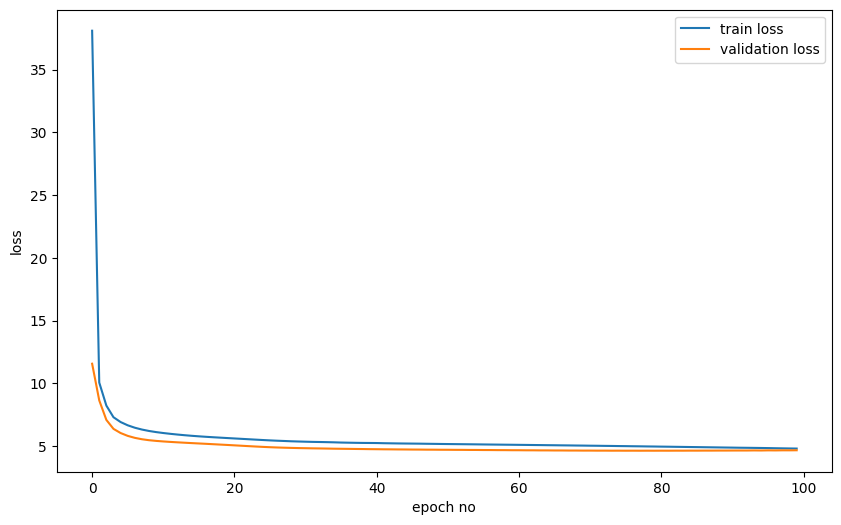

In [ ]:
# Plot the train loss, validation loss and test loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

**Checking the model on the test set:**

In [ ]:
model = LSTM(input_dim=D, hidden_dim=128, layer_dim=2, output_dim=2, dropout=0)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/project_DL/weights_bi.pth'))

<All keys matched successfully>

In [ ]:
# Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy() # Convert test target tensor to NumPy array
test_predictions_temp = []
test_predictions_sunshine = []

for i in range(len(test_target)):
  input_ = x_test[i].reshape(1, T, D) # Reshape input tensor to match the model's input format
  p_temp = model(input_)[0,0].item()  # Obtain mean_temp prediction from the model for the current input
  p_sunshine = model(input_)[0,1].item()  # same for sunshine

  # update the predictions list
  test_predictions_temp.append(p_temp)
  test_predictions_sunshine.append(p_sunshine)

**Checking mean_temp predictions:**

In [ ]:
plot_len = len(test_predictions_temp)
plot_df = weather[['date', 'mean_temp']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions_temp
plot_df.set_index('date', inplace=True)
plot_df.head(5)

,mean_temp,prediction
date,,
2016-10-24,11.4,9.771439
2016-10-25,11.8,11.724112
2016-10-26,13.0,13.787772
2016-10-27,12.2,13.412928
2016-10-28,13.5,13.310544


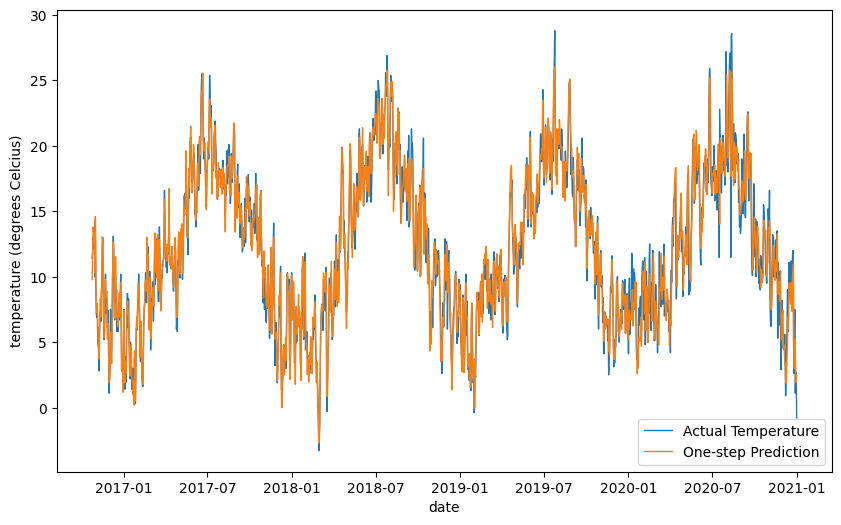

In [ ]:
# Plot mean_temp predictions vs. Actual mean_temp
plt.figure(figsize=(10, 6))
plt.plot(plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('temperature (degrees Celcius)')
plt.legend(loc='lower right')

In [ ]:
LSTM_error = pd.DataFrame(test_target[:,0], columns = ['targets'])
LSTM_error['predictions'] = test_predictions_temp
LSTM_error['error'] = LSTM_error['targets'] - LSTM_error['predictions']
LSTM_error['error_square'] = LSTM_error['error'] ** 2
err = LSTM_error['error_square'].mean()
print(f'Mean square error for mean_temp is: {err:.3f}')

Mean square error for mean_temp is: 2.042


Text(0.5, 1.0, 'Distribution of Differences')

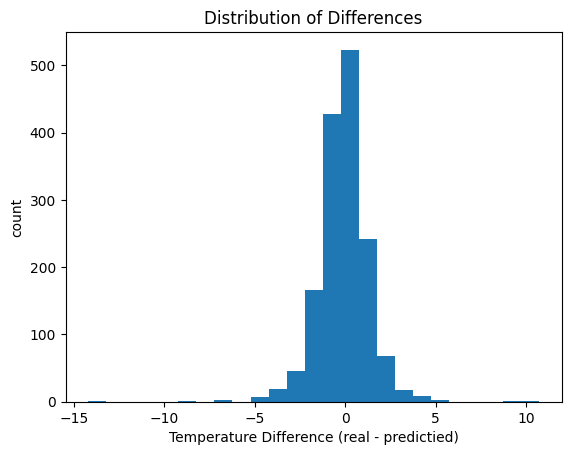

In [ ]:
plt.hist(LSTM_error['error'], bins=25)
plt.xlabel('Temperature Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

**Checking sunshine predictions:**

In [ ]:
plot_len = len(test_predictions_sunshine)
plot_df = weather[['date', 'sunshine']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions_sunshine
plot_df.set_index('date', inplace=True)
plot_df.head(5)

,sunshine,prediction
date,,
2016-10-24,0.0,3.138989
2016-10-25,0.3,2.236681
2016-10-26,2.1,1.966215
2016-10-27,2.8,3.211076
2016-10-28,3.3,4.897545


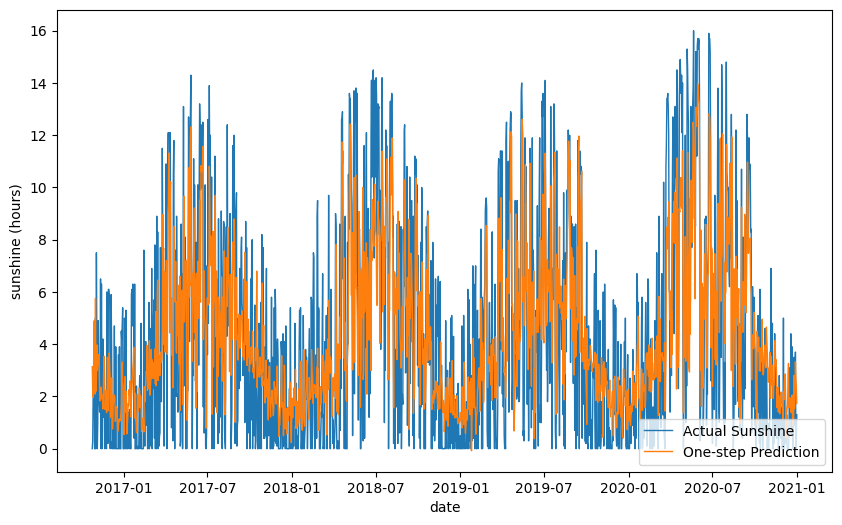

In [ ]:
# Plot sunshine predictions vs. Actual sunshine
plt.figure(figsize=(10, 6))
plt.plot(plot_df['sunshine'], label='Actual Sunshine', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('sunshine (hours)')
plt.legend(loc='lower right')

In [ ]:
LSTM_error = pd.DataFrame(test_target[:,1], columns = ['targets'])
LSTM_error['predictions'] = test_predictions_sunshine
LSTM_error['error'] = LSTM_error['targets'] - LSTM_error['predictions']
LSTM_error['error_square'] = LSTM_error['error'] ** 2
err = LSTM_error['error_square'].mean()
print(f'Mean square error for sunshine is: {err:.3f}')

Mean square error for sunshine is: 7.771


Text(0.5, 1.0, 'Distribution of Differences')

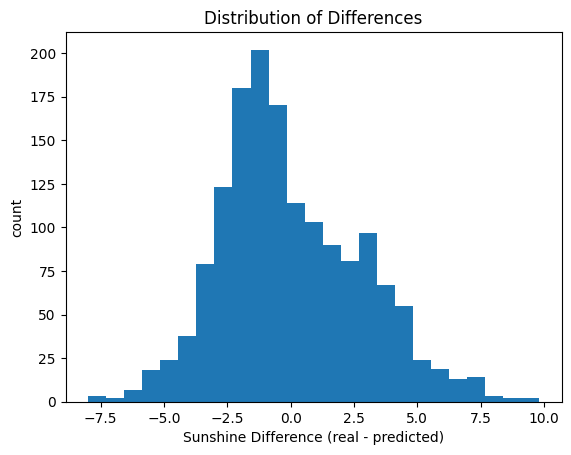

In [ ]:
plt.hist(LSTM_error['error'], bins=25)
plt.xlabel('Sunshine Difference (real - predicted)')
plt.ylabel('count')
plt.title('Distribution of Differences')